In [ ]:
import os
import re
import time
import pickle
import collections
import importlib
import datetime
import torch
import nltk
import pandas as pd
import numpy as np
from chardet import detect
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import defaultdict, Counter
from wordebd import WORDEBD
from vocab import Vocab, Vectors
from munch import Munch
from cnnlstmseq import CNNLSTMseq
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from nltk.tokenize import word_tokenize

# Autoreload extensions (if you're using Jupyter Notebook or IPython)
%load_ext autoreload
%autoreload 2

In [132]:
key=True

In [133]:
def get_encoding_type(file):
    with open(file, 'rb') as f:
        rawdata = f.read()
    return detect(rawdata)['encoding']

def detect_misspelling(source):
    pass

def replace_spelling(source):
    return re.sub("Åf", "'", source)

In [134]:
def preprocess_text(data):
    '''
    Preprocess text data
    @param data: list of text examples
    @return preprocessed_data: list of preprocessed text examples
    '''
    preprocessed_data = []
    for example in data:
        # Convert to lowercase
        example = example.lower()
        # Remove punctuation
        example = re.sub(r'[^\w\s]', '', example)
        preprocessed_data.append(example)
    return preprocessed_data

def load_pretrained_glove():
    print("Loading GloVe...")
    glv_vector = {}
    f = open('/embed/glove/glove.840B.300d.txt', encoding='utf-8')
    for line in f:
        values = line.split()
        word, coefs = values[0], np.asarray(values[1:], dtype='float')
        try:
            glv_vector[word] = coefs
        except ValueError:
            continue
    f.close()
    start_time = time.time()
    print(f"Took {time.time() - start_time} seconds to load pretrained GloVe model.")
    return glv_vector

def encode_labels(encoder, l):
    return encoder[l]

def _read_words(data, convmode=None):
    '''    
    Count the occurrences of all words
    @param convmode: str, None for non conversational scope, 'naive' for classic or naive approach, 'conv' for conversation depth into account (one additional dim and nested values)
    @param data: list of examples
    @return words: list of words (with duplicates)
    '''    
    words = []
    if convmode is None:
        for example in data:
            words += example.split()
    return words

def find_value_ranges(lst):
    value_ranges = []
    start_index = 0

    for i in range(1, len(lst)):
        if lst[i] != lst[i - 1]:
            value_ranges.append((start_index, i - 1))
            start_index = i

    # Add the last range
    value_ranges.append((start_index, len(lst) - 1))

    return value_ranges

In [135]:
# Read the CSV file
X_train = pd.read_csv('data/train_sent_emo_dya.csv', encoding='shift_jis')
X_test = pd.read_csv('data/test_sent_emo_dya.csv', encoding='utf-8')

# Display the first three rows
print(X_train.shape)
print(X_test.shape)

                                           Utterance          Speaker  \
0  also I was the point person on my companyÅfs t...         Chandler   
1                  You mustÅfve had your hands full.  The Interviewer   
2                            That I did. That I did.         Chandler   

   Emotion Sentiment  Dialogue_ID  Utterance_ID  Old_Dialogue_ID  \
0  neutral   neutral            0             0                0   
1  neutral   neutral            0             1                0   
2  neutral   neutral            0             2                0   

   Old_Utterance_ID  Season  Episode     StartTime       EndTime  
0                 0       8       21  00:16:16,059  00:16:21,731  
1                 1       8       21  00:16:21,940  00:16:23,442  
2                 2       8       21  00:16:23,442  00:16:26,389  


In [136]:
# Define features to drop
drop_features = list(X_train.columns[6:]) 

# Create DataFrame for target labels
y_train = pd.DataFrame()
y_test = pd.DataFrame()

y_train["Emotion"] = X_train["Emotion"].copy()
y_test["Emotion"] = X_test["Emotion"].copy()

y_train["Dialogue_ID"] = X_train["Dialogue_ID"].copy()
y_test["Dialogue_ID"] = X_test["Dialogue_ID"].copy()

# Drop features from X_train DataFrame
X_train = X_train.drop(drop_features, axis=1)
X_test = X_test.drop(drop_features, axis=1)

['Old_Dialogue_ID', 'Old_Utterance_ID', 'Season', 'Episode', 'StartTime', 'EndTime']
                                           Utterance          Speaker  \
0  also I was the point person on my companyÅfs t...         Chandler   
1                  You mustÅfve had your hands full.  The Interviewer   
2                            That I did. That I did.         Chandler   

   Emotion Sentiment  Dialogue_ID  Utterance_ID  
0  neutral   neutral            0             0  
1  neutral   neutral            0             1  
2  neutral   neutral            0             2  
   Emotion  Dialogue_ID
0  neutral            0
1  neutral            0
2  neutral            0


In [137]:
# Preprocess the "Utterance" column
X_train["Utterance"] = preprocess_text(X_train["Utterance"].tolist())
X_test["Utterance"] = preprocess_text(X_test["Utterance"].tolist())

# Print the first 14 rows of X_train DataFrame
print(X_train[:14])

                                            Utterance          Speaker  \
0   also i was the point person on my companys tra...         Chandler   
1                      you mustve had your hands full  The Interviewer   
2                               that i did that i did         Chandler   
3         so lets talk a little bit about your duties  The Interviewer   
4                                my duties  all right         Chandler   
5   now youll be heading a whole division so youll...  The Interviewer   
6                                               i see         Chandler   
7   but therell be perhaps 30 people under you so ...  The Interviewer   
8                                        good to know         Chandler   
9                               we can go into detail  The Interviewer   
10                               no dont i beg of you         Chandler   
11  all right then well have a definite answer for...  The Interviewer   
12                                    

In [138]:
checkFile1 = os.path.isfile("data/dump/label_encoder.pkl")
checkFile2 = os.path.isfile("data/dump/label_decoder.pkl")

if !(checkFile1 and checkFile2):
    labels = sorted(set(y_train.Emotion))
    labelEncoder = {label: i for i, label in enumerate(labels)}
    labelDecoder = {i: label for i, label in enumerate(labels)}

    pickle.dump(labelEncoder, open('data/dump/label_encoder.pkl', 'wb'))
    pickle.dump(labelDecoder, open('data/dump/label_decoder.pkl', 'wb'))
else:
    file1 = open('data/dump/label_encoder.pkl', 'rb')
    file2 = open('data/dump/label_decoder.pkl', 'rb')
    labelEncoder = pickle.load(file1)
    labelDecoder = pickle.load(file2)
    file1.close()
    file2.close()

In [151]:
# Apply label encoding to the "Emotion" column in y_train
y_train["Emotion"] = y_train["Emotion"].apply(lambda x: encode_labels(labelEncoder, x))
y_test["Emotion"] = y_test["Emotion"].apply(lambda x: encode_labels(labelEncoder, x))

# Copy the encoded "Emotion" column from y_train to X_train
X_train["Emotion"] = y_train["Emotion"].copy()
X_test["Emotion"] = y_test["Emotion"].copy()

In [ ]:
# Check if the file already exists
checkFile1 = os.path.isfile("data/dump/labels_train.pkl")
checkFile2 = os.path.isfile("data/dump/labels_test.pkl")

if !(checkFile1 and checkFile2):
    pickle.dump(X_train["Emotion"], open('data/dump/labels_train.pkl', 'wb'))
    pickle.dump(X_test["Emotion"], open('data/dump/labels_test.pkl', 'wb'))

In [171]:
# Check if the file already exists
checkFile = os.path.isfile("data/dump/train_labels.pkl")

# If the file doesn't exist, save the "Emotion" column of X_train DataFrame as train_labels.pkl
if !checkFile:
    pickle.dump(X_train["Emotion"], open('data/dump/train_labels.pkl', 'wb'))

In [107]:
# Define the file path
file_path = os.path.join(os.getcwd(), "data/wiki-news-300d-1M.vec")
    
# Check if the file exists
if os.path.isfile(file_path):
    print(f"{file_path} exists")
else:
    print(f"The file does not exist in the current directory.")

C:\Users\edayo\Downloads\4y2t\THSST-2\ug_thesis\ER_GAT\data/wiki-news-300d-1M.vec exists


In [179]:
# Define the vectors
vectors = Vectors(name="wiki-news-300d-1M.vec", url="data/", cache="data/")

# Cache the vectors file
# vectors.cache(name="data/wiki-news-300d-1M.vec", url="data/", cache="data/")

# Create vocabulary
vocab = Vocab(
    counter=collections.Counter(_read_words(X_train["Utterance"])),
    vectors=vectors,
    specials=['<pad>', '<unk>'],
    min_freq=5
)

# Print word embedding statistics
wv_size = vocab.vectors.size()
print('Total num. of words: {}, word vector dimension: {}'.format(
    wv_size[0],
    wv_size[1]
))

# Initialize word embeddings
ebd = WORDEBD(vocab, False)

Total num. of words: 1587, word vector dimension: 300


In [180]:
vocab.stoi["get"]

43

In [115]:
# Define the parameters using Munch
args = Munch({
    "cnn_filter_sizes": [3, 4, 5],
    "cnn_num_filters": 100,
    "cuda": -1,
    "mode": "train",
    "snapshot": '',
})

Creating an embedding

In [184]:
# Initialize the model with word embeddings and parameters
model = CNNLSTMseq(ebd, args)

# Print the model object
print(model)

CNNLSTMseq(
  (ebd): WORDEBD(
    (embedding_layer): Embedding(1587, 300)
  )
  (convs): ModuleList(
    (0): Conv1d(300, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(300, 100, kernel_size=(4,), stride=(1,))
    (2): Conv1d(300, 100, kernel_size=(5,), stride=(1,))
  )
  (lstm): LSTM(300, 150, bidirectional=True)
)


In [120]:
print("{}, Building embedding".format(
    datetime.datetime.now().strftime('%y/%m/%d %H:%M:%S')), flush=True)

if args.snapshot != '':
    if args.multitask:
        print("{}, Loading pretrained embedding from {}".format(
            datetime.datetime.now().strftime('%y/%m/%d %H:%M:%S'),
            '%s_%s.ebd' % (args.snapshot, args.task)
        ))
        model.load_state_dict(torch.load('%s_%s.ebd' % (args.snapshot, args.task)), strict=False)
    else:
        print("{}, Loading pretrained embedding from {}".format(
            datetime.datetime.now().strftime('%y/%m/%d %H:%M:%S'),
            '{}.ebd'.format(args.snapshot)
        ))
        model.load_state_dict(torch.load('{}.ebd'.format(args.snapshot)), strict=False)

24/03/06 13:38:50, Building embedding


In [174]:
model.train()

CNNLSTMseq(
  (ebd): WORDEBD(
    (embedding_layer): Embedding(1587, 300)
  )
  (convs): ModuleList(
    (0): Conv1d(300, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(300, 100, kernel_size=(4,), stride=(1,))
    (2): Conv1d(300, 100, kernel_size=(5,), stride=(1,))
  )
  (lstm): LSTM(300, 150, bidirectional=True)
)

Testing on smaller data. Uncomment to see the size of updated representations


In [187]:
# Sample data
data = ["how", "i see you hi", "foo my bad i want to see my babe"]

# Initialize variables
input_data = []
max_seq_len_list = []

# Process each conversation in the data
for conversation in data:
    # Tokenize each conversation into words
    conversation_tokens = conversation.split()

    # Convert words to indices
    turn_indices = [vocab.stoi[word] if word in vocab.stoi else vocab.stoi['<unk>'] for word in conversation_tokens]
    turn_tensor = torch.tensor(turn_indices, dtype=torch.long)  # Specify data type as long

    # Pad sequences to a fixed length (adjust this based on your model requirements)
    max_seq_len = len(turn_tensor)
    max_seq_len_list.append(max_seq_len)
    padded_turn = torch.nn.functional.pad(turn_tensor, pad=(0, max_seq_len - len(turn_tensor)))

    # Append the padded turn
    input_data.append(padded_turn)

# Determine the maximum sequence length across all conversations
max_seq_len = max(5, max(max_seq_len_list))

# Pad all conversations to the same maximum sequence length
for i, padded_turn in enumerate(input_data):
    input_data[i] = torch.nn.functional.pad(padded_turn, pad=(0, max_seq_len - len(padded_turn)))

# Stack all padded turns along a new dimension to create batched input
input_data_stacked = torch.stack(input_data)

# Construct input data dictionary
input_data_dict = {'Utterance': input_data_stacked}

# Perform the forward pass (inference) to obtain the numerical representation
with torch.no_grad():  # Disable gradient calculation during inference
    output_representation = model(input_data_dict)

# Output representation now contains the numerical representation of the input text dialog data
# print(output_representation)

In [188]:
input_data_dict

{'Utterance': tensor([[ 66,   0,   0,   0,   0,   0,   0,   0,   0],
         [  2,  70,   3,  88,   0,   0,   0,   0,   0],
         [  1,  18, 256,   2,  78,   5,  70,  18,   1]])}

This is just a duplicate of code above. Using this on train data

In [189]:
rangesTrain = find_value_ranges(X_train["Dialogue_ID"])
print(len(rangesTrain))

rangesTest = find_value_ranges(X_test["Dialogue_ID"])
print(len(rangesTest))

2160


In [191]:
start_time = time.time()

# Initialize variables
contexualEmbeddingsTrain = []
max_seq_len_list = []

# Check if the file exists
# If the file doesn't exist, compute updated representations and save them
if key:
    for range_pair, iteration in zip(rangesTrain, range(len(rangesTrain))):
        start_idx, end_idx = range_pair
        
        if iteration % 100 == 0:
            print(f"{iteration} out of {len(rangesTrain)}")
            
        conversation = X_train['Utterance'][start_idx:end_idx + 1]
        input_data = []

        for utterance in conversation:
            # Tokenize each conversation into words
            utterance_tokens = utterance.split()

            # Convert words to indices
            turn_indices = [vocab.stoi[word] if word in vocab.stoi else vocab.stoi['<unk>'] for word in utterance_tokens]   
            turn_tensor = torch.tensor(turn_indices, dtype=torch.long)  # Specify data type as long

            # Pad sequences to a fixed length (adjust this based on your model requirements)
            max_seq_len = len(turn_tensor)
            max_seq_len_list.append(max_seq_len)
            padded_turn = torch.nn.functional.pad(turn_tensor, pad=(0, max_seq_len - len(turn_tensor)))

            # Append the padded turn
            input_data.append(padded_turn)

        # Determine the maximum sequence length across all conversations
        max_seq_len = max(5, max(max_seq_len_list))

        # Pad all conversations to the same maximum sequence length
        for i, padded_turn in enumerate(input_data):
            input_data[i] = torch.nn.functional.pad(padded_turn, pad=(0, max_seq_len - len(padded_turn)))  

        # Stack all padded turns along a new dimension to create batched input
        input_data_stacked = torch.stack(input_data)

        # Construct input data dictionary
        input_data_dict = {'Utterance': input_data_stacked}

        # Perform the forward pass (inference) to obtain the numerical representation
        with torch.no_grad():  # Disable gradient calculation during inference
            output_representation = model(input_data_dict)

        contexualEmbeddingsTrain.append(output_representation)

        # Save the list to a file using pickle
#         if iteration % 800 == 0 | iteration == len(ranges):
    file_path = f'embed/u_prime_CNNBiLSTM_train.pkl'
    with open(file_path, 'wb') as file:
            pickle.dump(contexualEmbeddingsTrain, file)
#             contexualEmbeddingsTrain = []

# If the file exists, load the list from the file
else:
    file_path = 'embed/u_prime_CNNBiLSTM_train.pkl'
    with open(file_path, 'rb') as file:
        contexualEmbeddingsTrain = pickle.load(file)
        
# Record end time
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time
print(f"Contexualized train data - Elapsed time: {elapsed_time} seconds")

0 out of 2160


In [ ]:
start_time = time.time()

# Initialize variables
contexualEmbeddingsTest = []
max_seq_len_list = []

# Check if the file exists
# If the file doesn't exist, compute updated representations and save them
if key:
    for range_pair, iteration in zip(rangesTest, range(len(rangesTest))):
        start_idx, end_idx = range_pair
        
        if iteration % 100 == 0:
            print(f"{iteration} out of {len(rangesTest)}")
            
        conversation = X_test['Utterance'][start_idx:end_idx + 1]
        input_data = []

        for utterance in conversation:
            # Tokenize each conversation into words
            utterance_tokens = utterance.split()

            # Convert words to indices
            turn_indices = [vocab.stoi[word] if word in vocab.stoi else vocab.stoi['<unk>'] for word in utterance_tokens]   
            turn_tensor = torch.tensor(turn_indices, dtype=torch.long)  # Specify data type as long

            # Pad sequences to a fixed length (adjust this based on your model requirements)
            max_seq_len = len(turn_tensor)
            max_seq_len_list.append(max_seq_len)
            padded_turn = torch.nn.functional.pad(turn_tensor, pad=(0, max_seq_len - len(turn_tensor)))

            # Append the padded turn
            input_data.append(padded_turn)

        # Determine the maximum sequence length across all conversations
        max_seq_len = max(5, max(max_seq_len_list))

        # Pad all conversations to the same maximum sequence length
        for i, padded_turn in enumerate(input_data):
            input_data[i] = torch.nn.functional.pad(padded_turn, pad=(0, max_seq_len - len(padded_turn)))  

        # Stack all padded turns along a new dimension to create batched input
        input_data_stacked = torch.stack(input_data)

        # Construct input data dictionary
        input_data_dict = {'Utterance': input_data_stacked}

        # Perform the forward pass (inference) to obtain the numerical representation
        with torch.no_grad():  # Disable gradient calculation during inference
            output_representation = model(input_data_dict)

        contexualEmbeddingsTest.append(output_representation)

        # Save the list to a file using pickle
#         if iteration % 800 == 0 | iteration == len(ranges):
    file_path = f'embed/u_prime_CNNBiLSTM_test.pkl'
    with open(file_path, 'wb') as file:
            pickle.dump(contexualEmbeddingsTest, file)
#             contexualEmbeddingsTrain = []

# If the file exists, load the list from the file
else:
    file_path = 'embed/u_prime_CNNBiLSTM_test.pkl'
    with open(file_path, 'rb') as file:
        contexualEmbeddingsTest = pickle.load(file)
        
# Record end time
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time
print(f"Contexualized test data - Elapsed time: {elapsed_time} seconds")

    "# last checkpoint\n",
    "# 8230   8231\n",
    "# 8232   8236\n",
    "# 8237   8241\n",
    "# 8242   8248\n",
    "# 8249   8251"

In [ ]:
# Check if the file exists
checkFile = os.path.isfile("data/dump/speaker_encoder_train.pkl")
encodedSpeakersTrain = []

if !checkFile:
    for range_pair in rangesTrain:
        start_idx, end_idx = range_pair
        speaker_per_dialog = X_train['Speaker'][start_idx:end_idx + 1].copy()
        speaker_feature = sorted(set(speaker_per_dialog))
        speaker_encoder = {feature: i for i, feature in enumerate(speaker_feature)}
        speaker_decoder = {i: feature for i, feature in enumerate(speaker_feature)}

        encoded_speaker = speaker_per_dialog.replace(speaker_encoder)
        encodedSpeakersTrain.append(encoded_speaker)

    # Save encoded speaker list and ranges to a file using pickle
    file_path = 'data/dump/speaker_encoder_train.pkl'
    with open(file_path, 'wb') as file:
        pickle.dump([encodedSpeakersTrain, rangesTrain], file)
else:
    # Load encoded speaker list and ranges from the existing pickle file
    file = open('data/dump/speaker_encoder_train.pkl', "rb")
    encodedSpeakersTrain, rangesTrain = pickle.load(file)
    file.close()

In [124]:
# Check if the file exists
checkFile = os.path.isfile("data/dump/speaker_encoder_test.pkl")
encodedSpeakersTest = []

if !checkFile:
    for range_pair in rangesTest:
        start_idx, end_idx = range_pair
        speaker_per_dialog = X_test['Speaker'][start_idx:end_idx + 1].copy()
        speaker_feature = sorted(set(speaker_per_dialog))
        speaker_encoder = {feature: i for i, feature in enumerate(speaker_feature)}
        speaker_decoder = {i: feature for i, feature in enumerate(speaker_feature)}

        encoded_speaker = speaker_per_dialog.replace(speaker_encoder)
        encodedSpeakersTest.append(encoded_speaker)

    # Save encoded speaker list and ranges to a file using pickle
    file_path = 'data/dump/speaker_encoder_test.pkl'
    with open(file_path, 'wb') as file:
        pickle.dump([encodedSpeakersTest, rangesTest], file)
else:
    # Load encoded speaker list and ranges from the existing pickle file
    file = open('data/dump/speaker_encoder_test.pkl', "rb")
    encodedSpeakersTest, rangesTest = pickle.load(file)
    file.close()

Unsupervised visualization

In [125]:
# # Concatenate all the tensors representing individual utterances
# concatenated_tensors = []
# for dialogue_tensor in updated_representations:
#     concatenated_tensors.extend(dialogue_tensor)

# # Convert the concatenated list of tensors into a single tensor
# tensor_utterances = torch.stack(concatenated_tensors)

In [153]:
label_decoder

{0: 'anger',
 1: 'fear',
 2: 'neutral',
 3: 'sadness',
 4: 'surprise',
 5: 'joy',
 6: 'disgust'}

In [154]:
list(label_decoder.values())
num_instance=len(X_train)

In [155]:
# Calculate the counts for each unique label
unique_labels, label_counts = np.unique(list(X_train["Emotion"][:num_instance]), return_counts=True)

# Print the counts for each unique label
for label, count in zip(unique_labels, label_counts):
    print(f"{label}: {count} occurrences")

0: 1500 occurrences
1: 338 occurrences
2: 5960 occurrences
3: 876 occurrences
4: 1490 occurrences
5: 2312 occurrences
6: 364 occurrences


Visualize utterance embeddnig (u') with T-SNE

In [156]:
# labels = torch.tensor(X_train["Emotion"][:num_instance])

In [161]:
# label_decoder

{0: 'anger',
 1: 'fear',
 2: 'neutral',
 3: 'sadness',
 4: 'surprise',
 5: 'joy',
 6: 'disgust'}

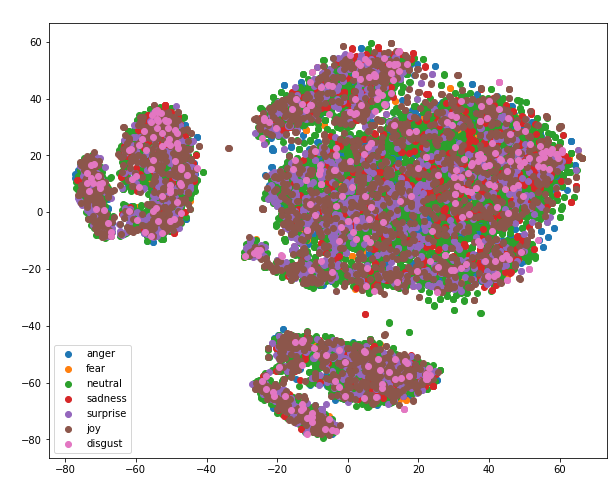

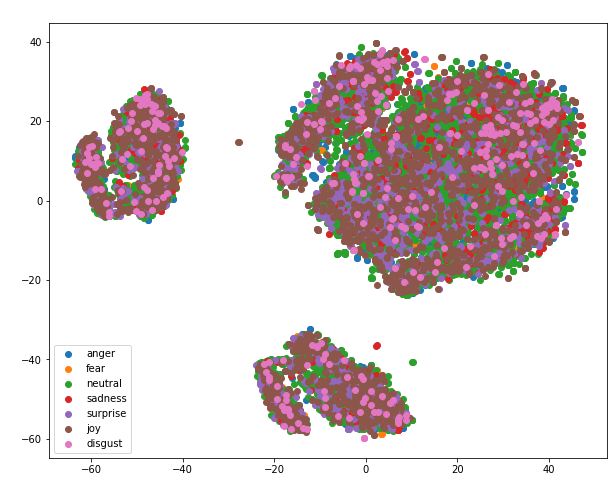

In [164]:
# runTSNE = 1
# if runTSNE:
#     from sklearn.manifold import TSNE
#     import matplotlib.pyplot as plt

#     # List of perplexity values to loop over
#     perplexity_values = [50, 100]

#     # Loop over each perplexity value
#     for perplexity in perplexity_values:
#         # Initialize t-SNE with the current perplexity value
#         tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)

#         # Fit and transform the data using t-SNE
#         h_prime_tsne = tsne.fit_transform(tensor_utterances[:num_instance].detach().numpy())

#         # Plot the node embeddings with different colors for each label
#         plt.figure(figsize=(10, 8))
#         for label, emotion in zip(range(len(label_encoder)), label_encoder):
#             indices = (labels == label).nonzero().squeeze()
#             plt.scatter(h_prime_tsne[indices, 0], h_prime_tsne[indices, 1], label=f'{emotion}')
#         plt.title(f'Utterance Embeddings (Train) Visualization (t-SNE) - Perplexity {perplexity}', color="white")
#         plt.xlabel('Dimension 1', color="white")
#         plt.ylabel('Dimension 2', color="white")
#         plt.legend()
#         plt.show()

 Visualize utterance embedding (u') with PCA

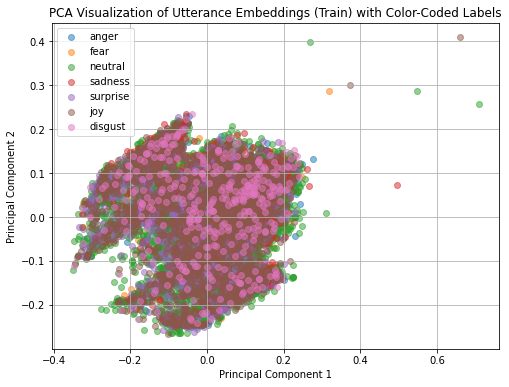

In [182]:
# pca = PCA(n_components=2)
# pca_result = pca.fit_transform(tensor_utterances[:num_instance].detach().numpy())

# # Plot the PCA result with color-coded labels
# plt.figure(figsize=(8, 6))
# for label in np.unique(labels):
#     indices = labels == label
#     plt.scatter(pca_result[indices, 0], pca_result[indices, 1], label=f'{label_decoder[label]}', alpha=0.5)
# plt.title('PCA Visualization of Utterance Embeddings (Train) with Color-Coded Labels')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.legend()
# plt.grid(True)
# plt.show()